## Normalizing Flows

Your task is to implement a version of Normalizing Flow for image generation. Our implementation will be based on RealNVP (https://arxiv.org/pdf/1605.08803.pdf) and we will be training on one class from MNIST. Your task is to read the paper in details and implement simple version of the algorithm from the paper:


1. Implement simple CouplingLayers (see RealNVP paper) with neural networks using a few fully connected layers with hidden activations of your choice. More on the CouplingLayers can be also found in https://arxiv.org/pdf/1410.8516.pdf. Remember to implement properly logarithm of a Jacobian determinant calculation. Implement only single scale architecture, ignore multiscale architecture with masked convolution and batch normalization. (2 points)
2. Implement RealNVP class combining many CouplingLayers with proper masking pattern (rememeber to alternate between unmodified pixels) with forward and inverse flows. (1 points)
3. Implement a loss function `nf_loss` (data log-likelihood) for the model. Hint: check `torch.distributions` (1 point)
4. Train your model to achieve good looking samples (similar to training set - similar to that appended to assignmenmt on moodle). The training process should take between 5-10 minutes. (2 points)
5. Sample from your model and pick 2 images (as visually different as possible) from your samples and plot 10 images that correspond to equally spaced linear interpolations in latent space between those images you picked. (1 point)
6. Use method from section 5.2 from https://arxiv.org/pdf/1410.8516.pdf with trained model and inpaint 5 sampled images with different random parts of your image occluded (50% of the image must be occluded). (2 point)
7. Write a report describing your solution, add loss plots and samples from the model. Write which hyperparameter sets worked for you and which did not. (1 point)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

In [85]:
def plot(samples):
    length = len(samples)
    fig, ax = plt.subplots(1, length, figsize=(2*length, 2))
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    for j in range(length):
        ax[j].imshow(samples[j].cpu().numpy())
        ax[j].axis('off')
    plt.show()
    

class Coupling_layer(nn.Module):        
    def __init__(self, size, mask):

        super(Coupling_layer, self).__init__()
        size_in = np.ceil(size / 2).astype(int)
        size_out = np.floor(size / 2).astype(int)
        self.s_block = nn.Sequential(nn.Linear(size_in, 256), nn.ReLU(),
                                     nn.Linear(256, 256), nn.ReLU(),
                                     nn.Linear(256, size_out), nn.Tanh())
        
        self.t_block = nn.Sequential(nn.Linear(size_in, 256), nn.ReLU(),
                                     nn.Linear(256, 256), nn.ReLU(),
                                     nn.Linear(256, size_out))

        # self.s_fc = nn.Linear(size, size)
        # self.t_fc = nn.Linear(size, size)
        # self.act = nn.ReLU()
        # self.out_act = nn.TanH()
        self.mask = mask % 2 == 0

 
    def forward_flow(self, x):
      temp_x = torch.zeros_like(x)
      x_1 = x[:, self.mask]
      x_2 = x[:, ~self.mask]

      s_out = self.s_block(x_1)
      t_out = self.t_block(x_1)

      x_2 = x_2 * torch.exp(s_out) + t_out
      
      temp_x[:, self.mask] = x_1
      temp_x[:, ~self.mask] = x_2
      jacobian = s_out.sum(dim=1)

      return temp_x, jacobian
     
    def inverse_flow(self, x):
      temp_x = torch.zeros_like(x)
      x_1 = x[:, self.mask]
      x_2 = x[:, ~self.mask]

      s_out = self.s_block(x_1)
      t_out = self.t_block(x_1)

      x_2 = (x_2 - t_out) * torch.exp(-1 * s_out) 
      
      temp_x[:, self.mask] = x_1
      temp_x[:, ~self.mask] = x_2
      jacobian = -1 * s_out.sum(dim=1)

      return temp_x, jacobian
    
    
class RealNVP(nn.Module):
    def __init__(self, size, num_cpl):
        super(RealNVP, self).__init__()
        self.size = size
        self.mask = torch.arange(size)
        self.layers = nn.ModuleList()
        self.create_layers(num_cpl)

    
    def create_layers(self, num_cpl):
      for i in range(num_cpl):
        self.layers.append(Coupling_layer(self.size, self.mask))
        self.mask = 1 - self.mask

    def forward_flow(self, x):
        x = x.view(x.shape[0], -1)
        det_jcb_sum = x.new_zeros(x.shape[0])
        for lay in self.layers:
          x, jacobian = lay.forward_flow(x)
          det_jcb_sum += jacobian

        return x, det_jcb_sum
    def inverse_flow(self, z):
        z = z.view(z.shape[0], -1)
        det_jcb_sum = z.new_zeros(z.shape[0])

        for lay in reversed(self.layers):
          z, jacobian = lay.inverse_flow(z)
          det_jcb_sum += jacobian

        return z, det_jcb_sum

        
        
def nf_loss(z, logdetJ, dist, device):
    z = z.to("cpu")
    log_p = dist.log_prob(z).to(device)
    return -(log_p + logdetJ).mean()


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST(root=r'./mnist/', 
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)
x = (dataset.data.float() / 255. - 0.5)
y = dataset.targets
x = x[y == 5]

dataloader = DataLoader(x, batch_size=128, shuffle=True)

In [87]:
j = next(iter(dataloader))
print(j.shape)

torch.Size([128, 28, 28])


In [88]:
n_epochs = 1600
lr = 1e-3
#eps = ...
base = torch.distributions.MultivariateNormal(
            torch.zeros(28 * 28), torch.eye(784)
        )

model = RealNVP(28 * 28, 6).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch: 1/1600 Loss: -271.1712
torch.Size([5, 28, 28])


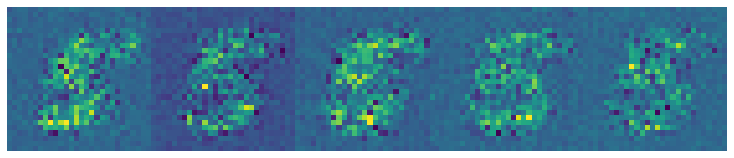

Epoch: 11/1600 Loss: -1134.5779
torch.Size([5, 28, 28])


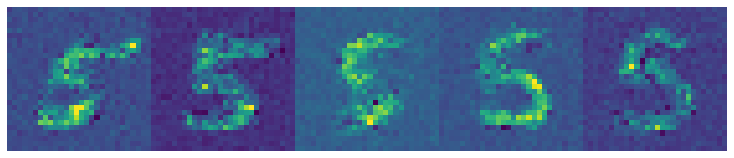

Epoch: 21/1600 Loss: -1193.5972
torch.Size([5, 28, 28])


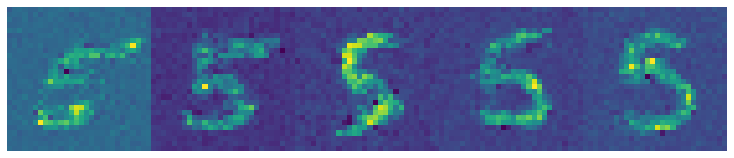

Epoch: 31/1600 Loss: -433.5506
torch.Size([5, 28, 28])


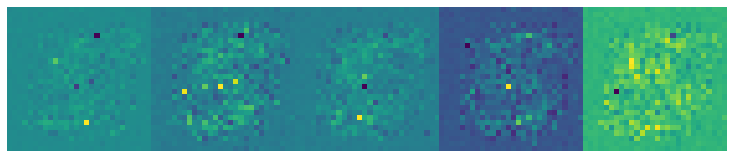

Epoch: 41/1600 Loss: -1089.6276
torch.Size([5, 28, 28])


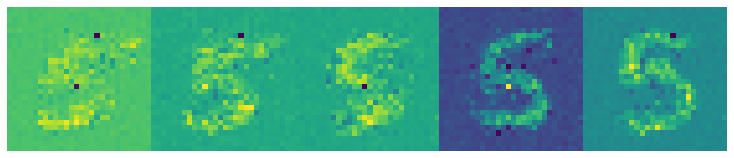

Epoch: 51/1600 Loss: -1167.1049
torch.Size([5, 28, 28])


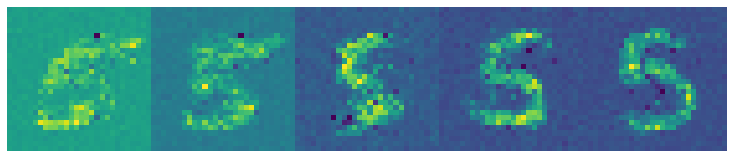

Epoch: 61/1600 Loss: -1195.6764
torch.Size([5, 28, 28])


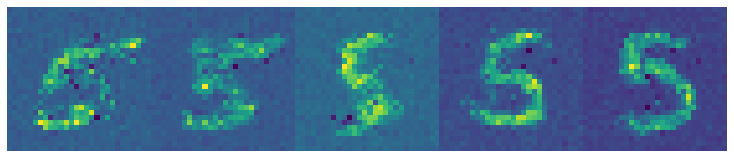

Epoch: 71/1600 Loss: -1213.9918
torch.Size([5, 28, 28])


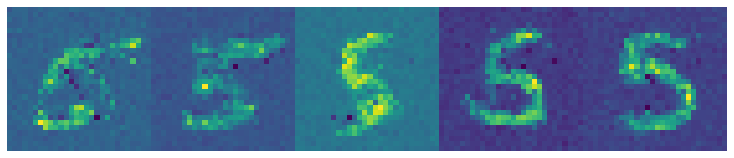

Epoch: 81/1600 Loss: -1223.2067
torch.Size([5, 28, 28])


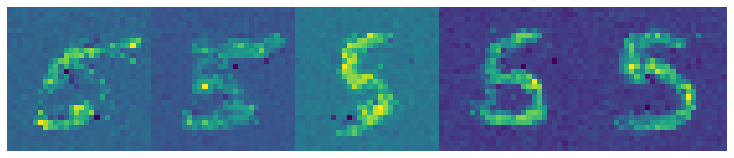

Epoch: 91/1600 Loss: -1234.6378
torch.Size([5, 28, 28])


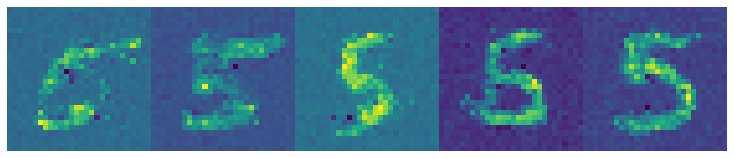

Epoch: 101/1600 Loss: -1241.0096
torch.Size([5, 28, 28])


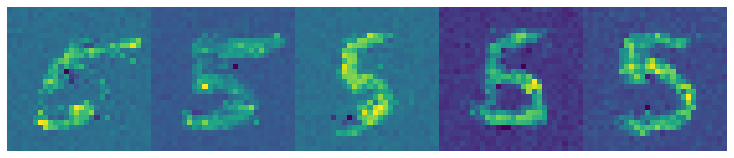

Epoch: 111/1600 Loss: -1248.1255
torch.Size([5, 28, 28])


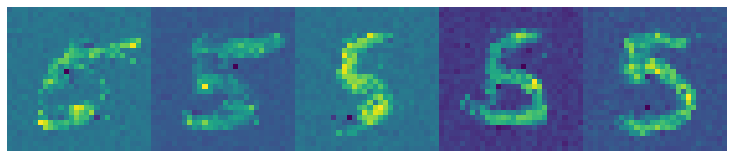

Epoch: 121/1600 Loss: -1255.9023
torch.Size([5, 28, 28])


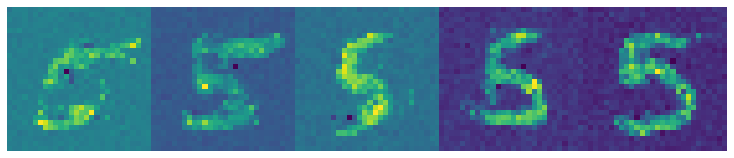

Epoch: 131/1600 Loss: -1259.4601
torch.Size([5, 28, 28])


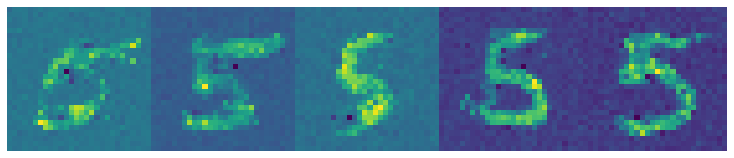

Epoch: 141/1600 Loss: -1264.4377
torch.Size([5, 28, 28])


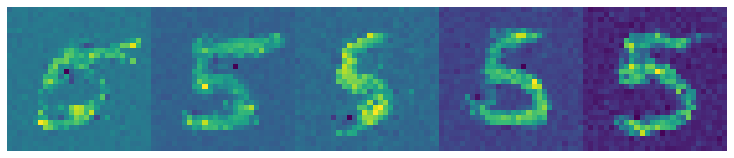

Epoch: 151/1600 Loss: -1269.3469
torch.Size([5, 28, 28])


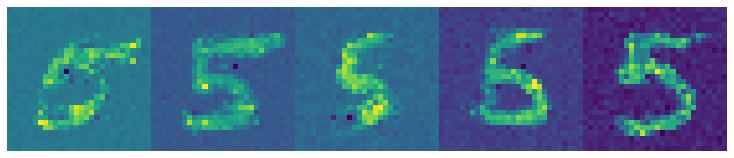

Epoch: 161/1600 Loss: -1269.5549
torch.Size([5, 28, 28])


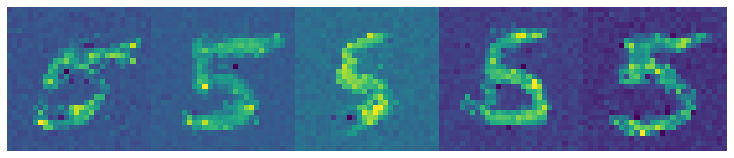

Epoch: 171/1600 Loss: -1278.0763
torch.Size([5, 28, 28])


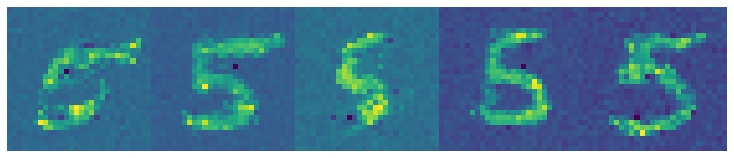

Epoch: 181/1600 Loss: -1282.6401
torch.Size([5, 28, 28])


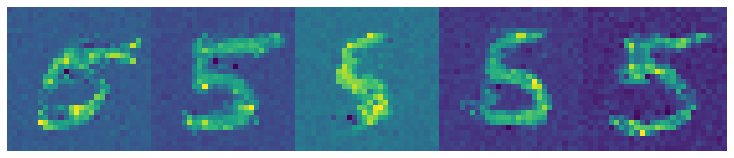

Epoch: 191/1600 Loss: -1283.6515
torch.Size([5, 28, 28])


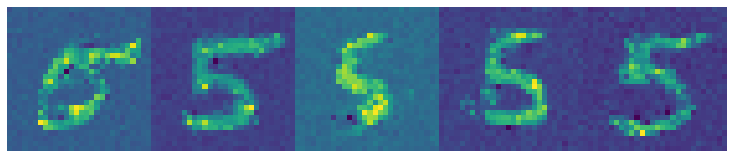

Epoch: 201/1600 Loss: -1289.8640
torch.Size([5, 28, 28])


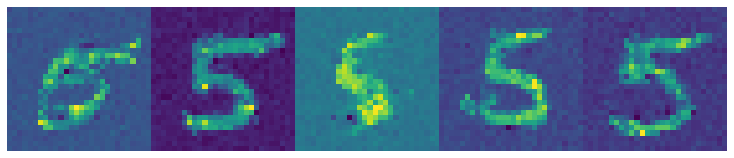

Epoch: 211/1600 Loss: -1291.0289
torch.Size([5, 28, 28])


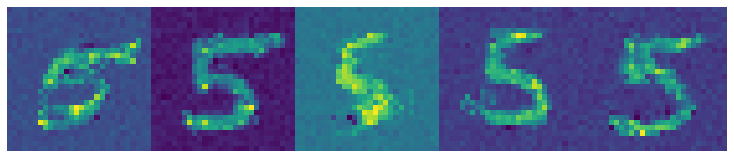

Epoch: 221/1600 Loss: -1290.9815
torch.Size([5, 28, 28])


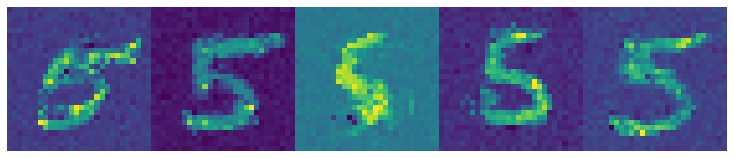

Epoch: 231/1600 Loss: -1293.0216
torch.Size([5, 28, 28])


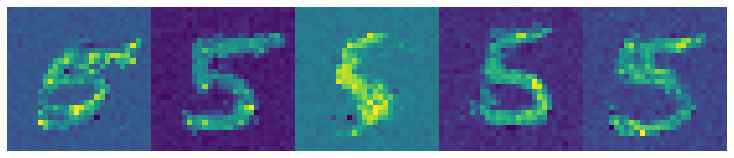

Epoch: 241/1600 Loss: -1298.8124
torch.Size([5, 28, 28])


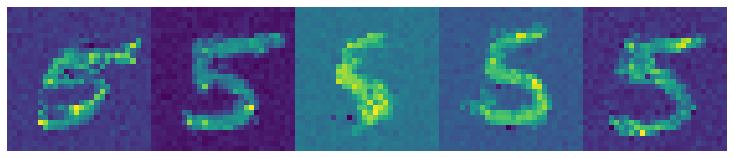

Epoch: 251/1600 Loss: -1294.9058
torch.Size([5, 28, 28])


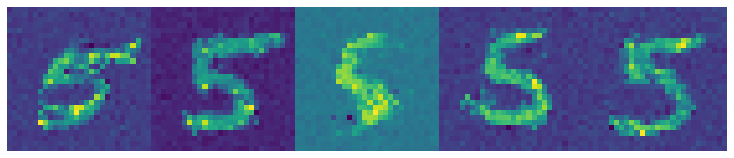

Epoch: 261/1600 Loss: -1299.9617
torch.Size([5, 28, 28])


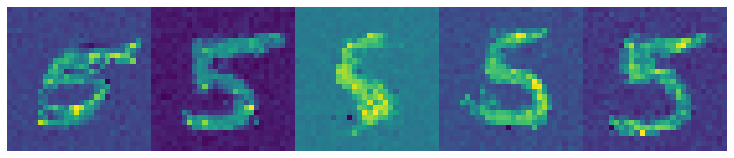

Epoch: 271/1600 Loss: -1300.7538
torch.Size([5, 28, 28])


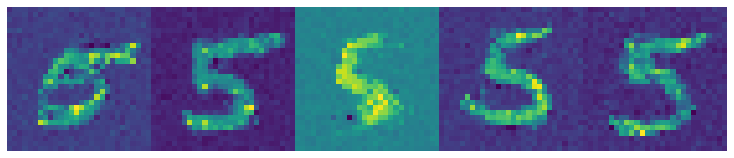

Epoch: 281/1600 Loss: -1303.4687
torch.Size([5, 28, 28])


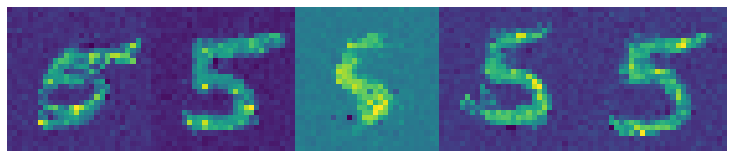

Epoch: 291/1600 Loss: -1301.7253
torch.Size([5, 28, 28])


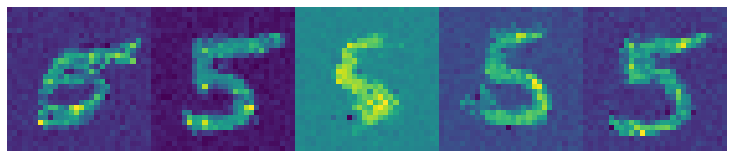

Epoch: 301/1600 Loss: -1300.9098
torch.Size([5, 28, 28])


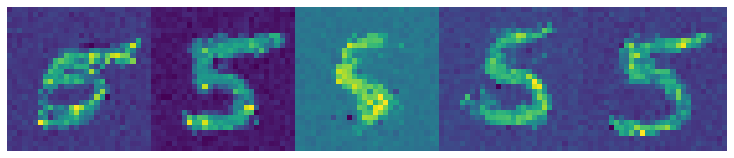

Epoch: 311/1600 Loss: -1310.4713
torch.Size([5, 28, 28])


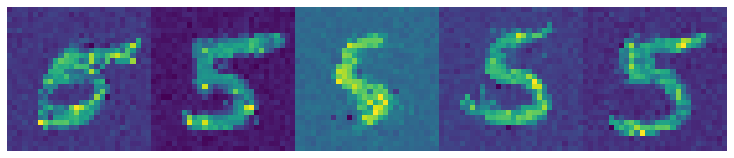

Epoch: 321/1600 Loss: -1296.9590
torch.Size([5, 28, 28])


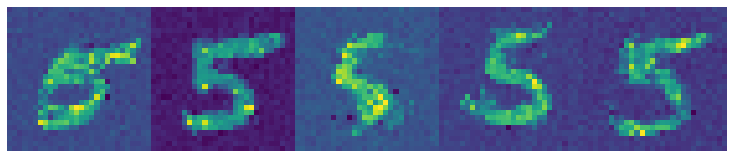

Epoch: 331/1600 Loss: -1308.7441
torch.Size([5, 28, 28])


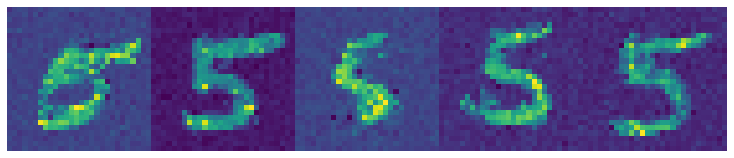

Epoch: 341/1600 Loss: -1316.4142
torch.Size([5, 28, 28])


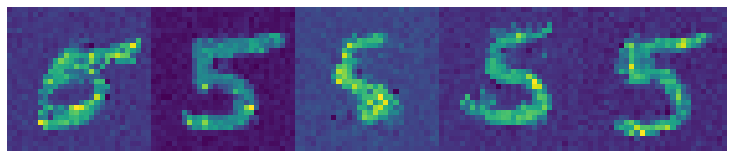

Epoch: 351/1600 Loss: -1315.5697
torch.Size([5, 28, 28])


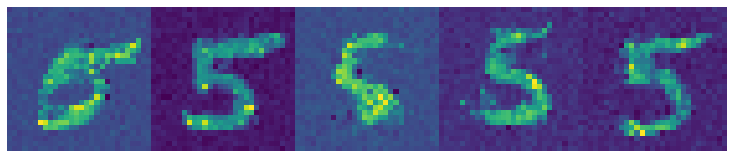

Epoch: 361/1600 Loss: -1316.4047
torch.Size([5, 28, 28])


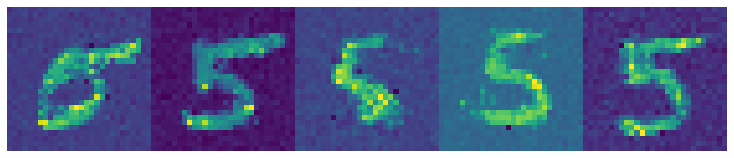

Epoch: 371/1600 Loss: -1312.6347
torch.Size([5, 28, 28])


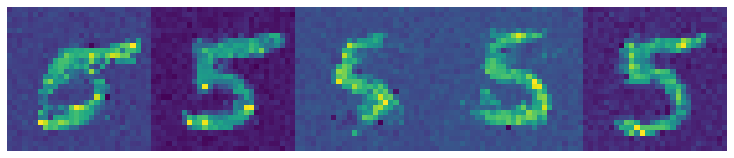

Epoch: 381/1600 Loss: -1315.9794
torch.Size([5, 28, 28])


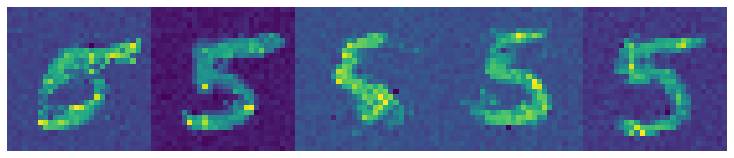

Epoch: 391/1600 Loss: -1316.8987
torch.Size([5, 28, 28])


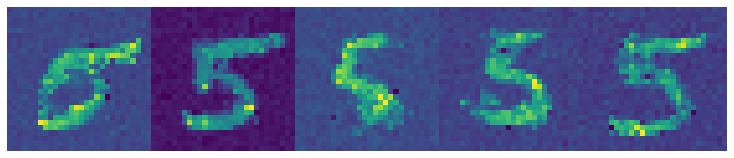

Epoch: 401/1600 Loss: -1316.2534
torch.Size([5, 28, 28])


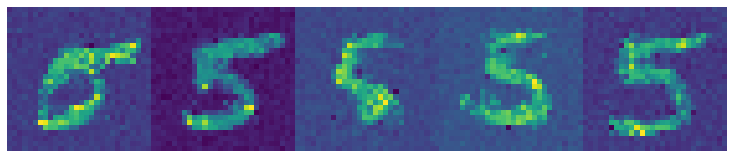

Epoch: 411/1600 Loss: -1321.4207
torch.Size([5, 28, 28])


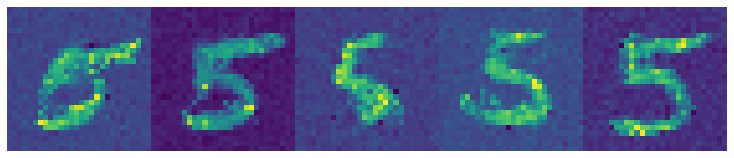

Epoch: 421/1600 Loss: -1321.6440
torch.Size([5, 28, 28])


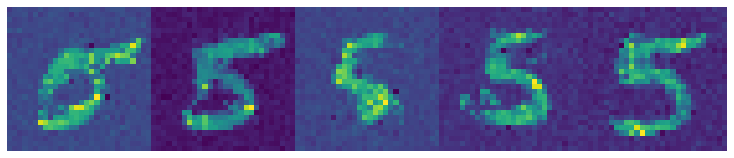

Epoch: 431/1600 Loss: -1292.5774
torch.Size([5, 28, 28])


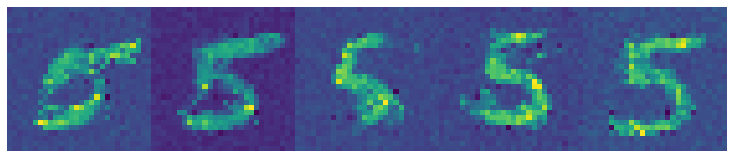

Epoch: 441/1600 Loss: -1294.3185
torch.Size([5, 28, 28])


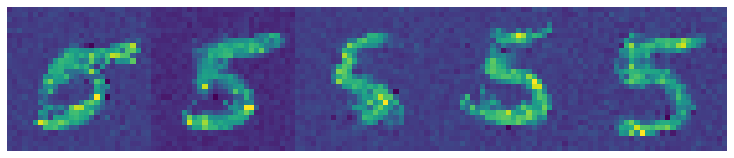

Epoch: 451/1600 Loss: -1325.6678
torch.Size([5, 28, 28])


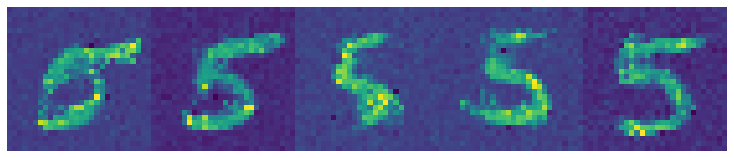

Epoch: 461/1600 Loss: -1319.4512
torch.Size([5, 28, 28])


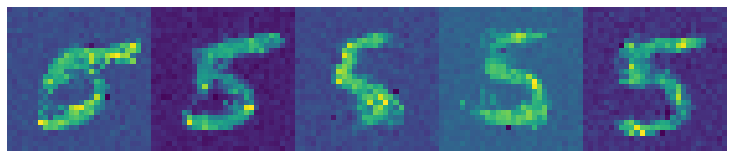

Epoch: 471/1600 Loss: -1326.1370
torch.Size([5, 28, 28])


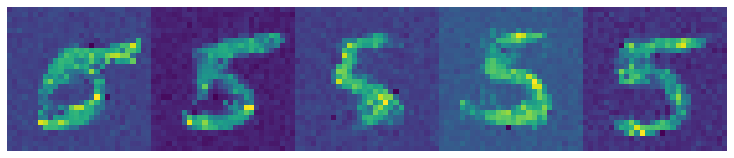

Epoch: 481/1600 Loss: -1320.1105
torch.Size([5, 28, 28])


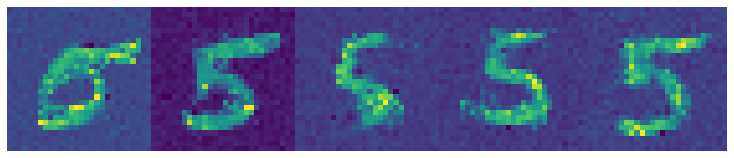

Epoch: 491/1600 Loss: -1327.0819
torch.Size([5, 28, 28])


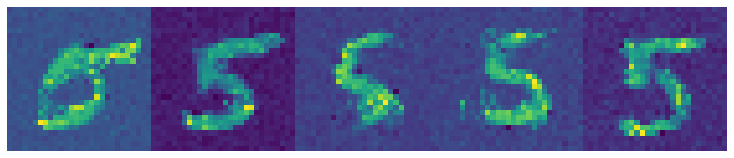

Epoch: 501/1600 Loss: -1327.3091
torch.Size([5, 28, 28])


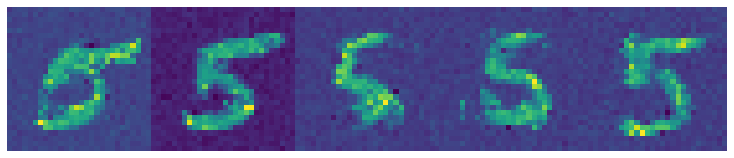

Epoch: 511/1600 Loss: -1326.4540
torch.Size([5, 28, 28])


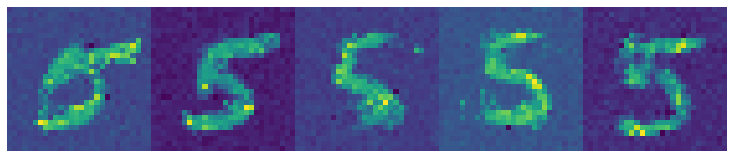

Epoch: 521/1600 Loss: -1320.7608
torch.Size([5, 28, 28])


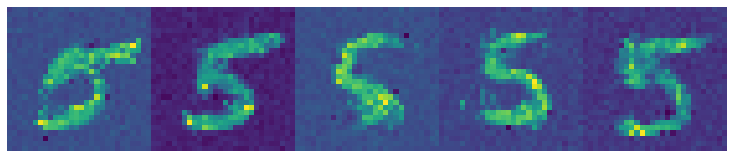

Epoch: 531/1600 Loss: -1327.6537
torch.Size([5, 28, 28])


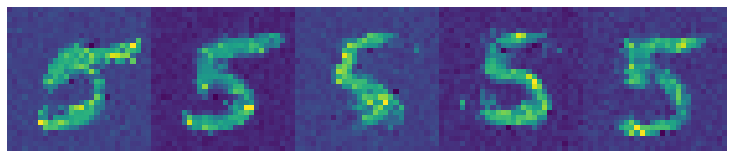

Epoch: 541/1600 Loss: -1329.3585
torch.Size([5, 28, 28])


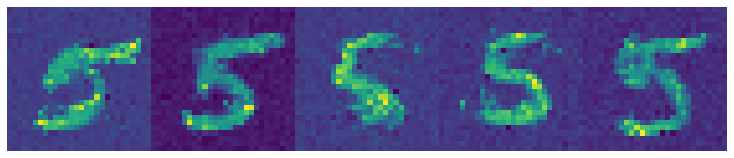

Epoch: 551/1600 Loss: -1315.8022
torch.Size([5, 28, 28])


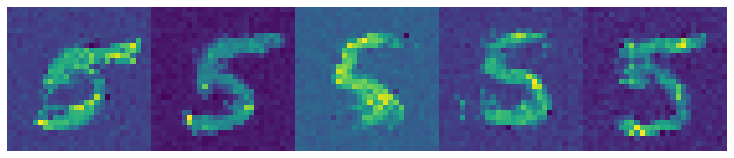

Epoch: 561/1600 Loss: -1329.0994
torch.Size([5, 28, 28])


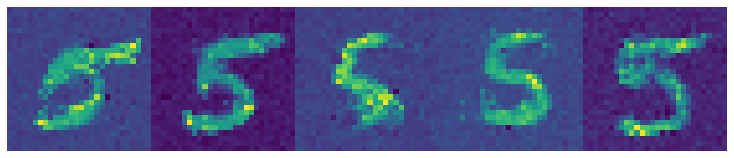

Epoch: 571/1600 Loss: -1328.5501
torch.Size([5, 28, 28])


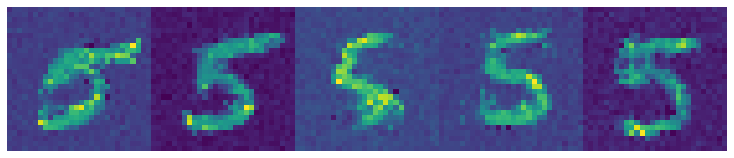

Epoch: 581/1600 Loss: -1326.9579
torch.Size([5, 28, 28])


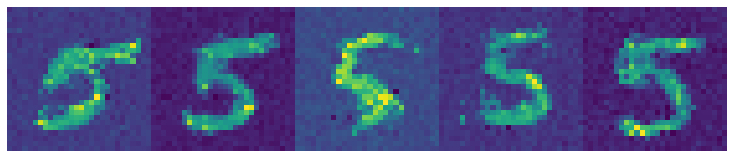

Epoch: 591/1600 Loss: -1330.9017
torch.Size([5, 28, 28])


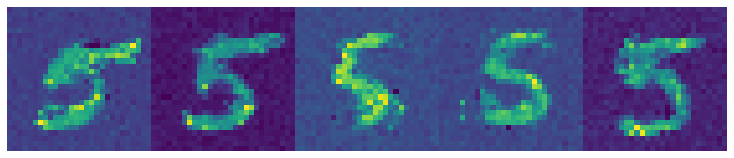

Epoch: 601/1600 Loss: -1322.7626
torch.Size([5, 28, 28])


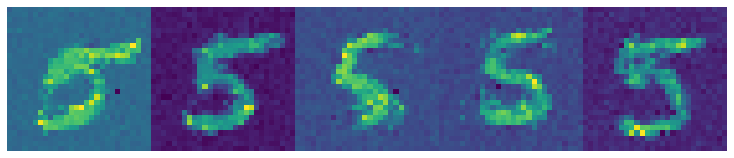

Epoch: 611/1600 Loss: -1328.1828
torch.Size([5, 28, 28])


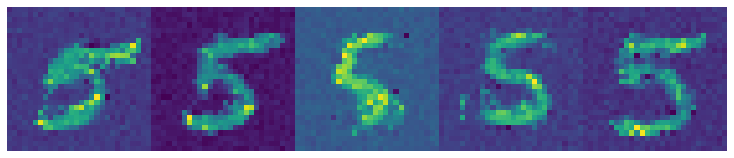

Epoch: 621/1600 Loss: -1312.4990
torch.Size([5, 28, 28])


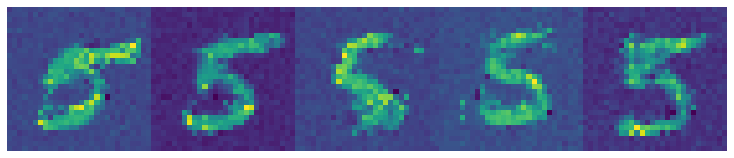

Epoch: 631/1600 Loss: -1323.1458
torch.Size([5, 28, 28])


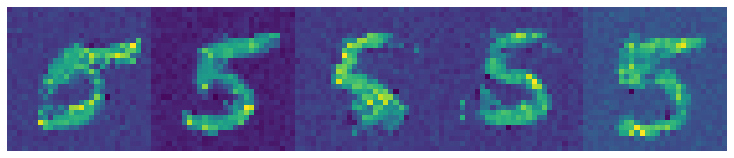

Epoch: 641/1600 Loss: -1324.3999
torch.Size([5, 28, 28])


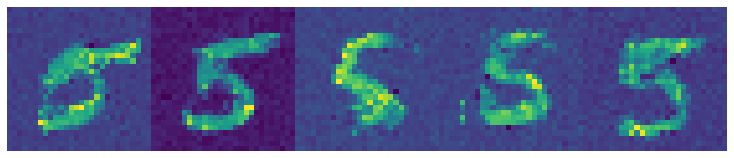

Epoch: 651/1600 Loss: -1322.9938
torch.Size([5, 28, 28])


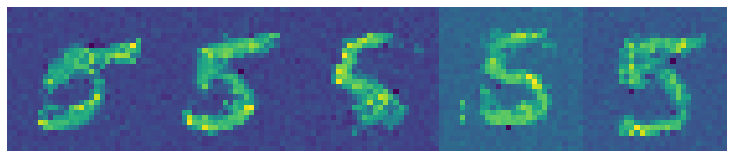

Epoch: 661/1600 Loss: -1330.2756
torch.Size([5, 28, 28])


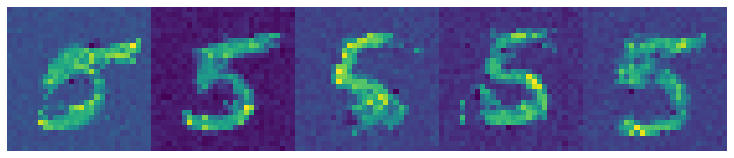

Epoch: 671/1600 Loss: -1334.0862
torch.Size([5, 28, 28])


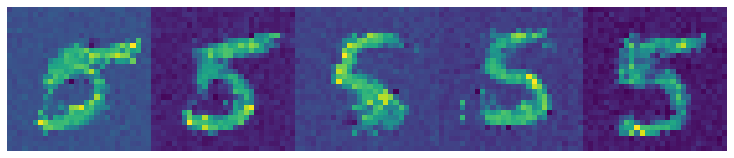

Epoch: 681/1600 Loss: -1327.1334
torch.Size([5, 28, 28])


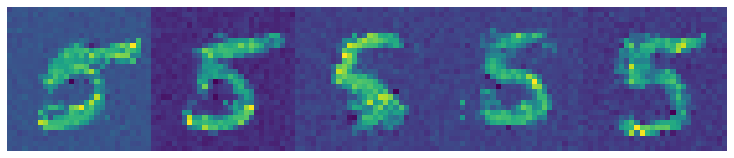

Epoch: 691/1600 Loss: -1328.2638
torch.Size([5, 28, 28])


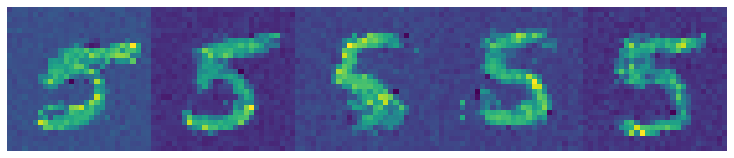

Epoch: 701/1600 Loss: -1331.5099
torch.Size([5, 28, 28])


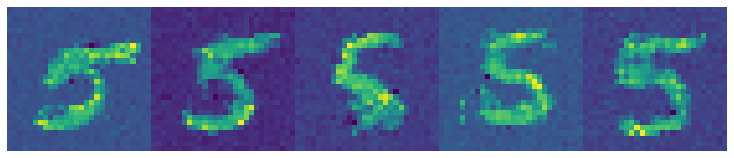

Epoch: 711/1600 Loss: -1326.8873
torch.Size([5, 28, 28])


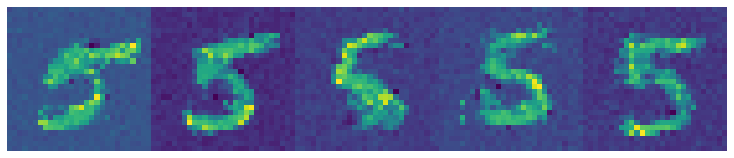

Epoch: 721/1600 Loss: -1312.3595
torch.Size([5, 28, 28])


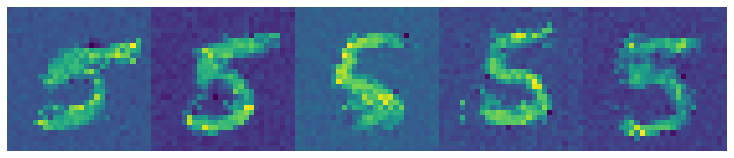

Epoch: 731/1600 Loss: -1333.1521
torch.Size([5, 28, 28])


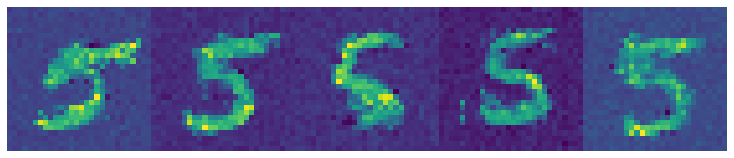

Epoch: 741/1600 Loss: -1334.3265
torch.Size([5, 28, 28])


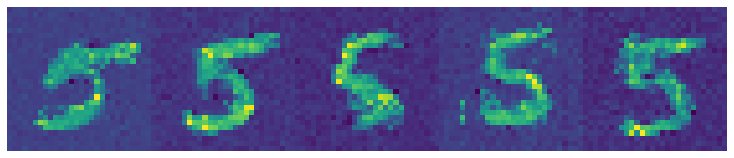

Epoch: 751/1600 Loss: -1299.5131
torch.Size([5, 28, 28])


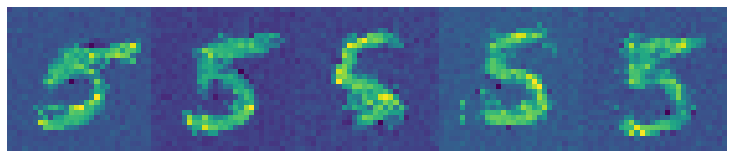

Epoch: 761/1600 Loss: -1324.2444
torch.Size([5, 28, 28])


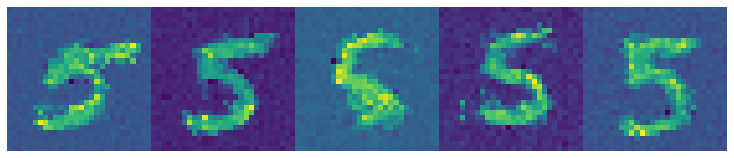

Epoch: 771/1600 Loss: -1334.3796
torch.Size([5, 28, 28])


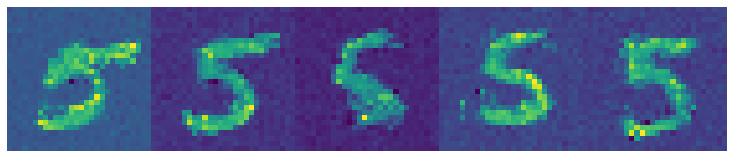

Epoch: 781/1600 Loss: -1278.5182
torch.Size([5, 28, 28])


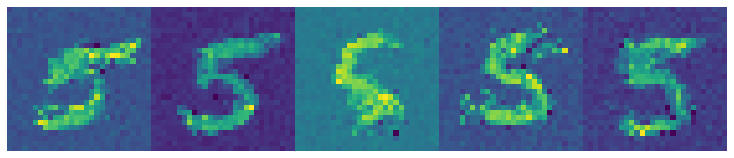

Epoch: 791/1600 Loss: -1330.0708
torch.Size([5, 28, 28])


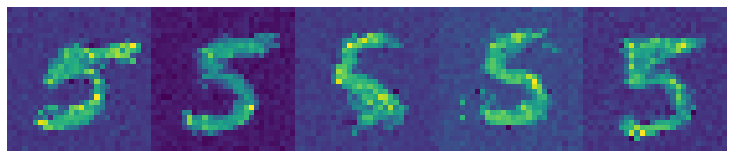

Epoch: 801/1600 Loss: -1328.2957
torch.Size([5, 28, 28])


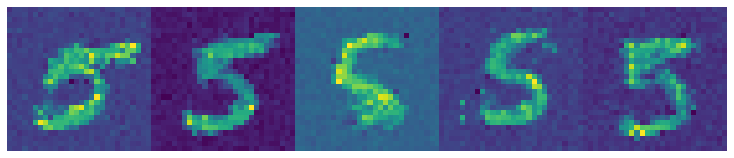

Epoch: 811/1600 Loss: -1321.9467
torch.Size([5, 28, 28])


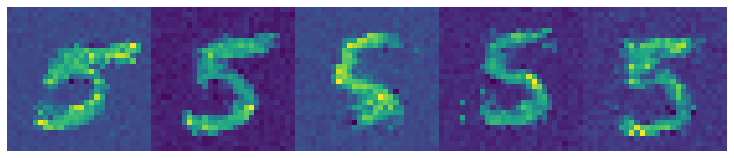

Epoch: 821/1600 Loss: -1332.8550
torch.Size([5, 28, 28])


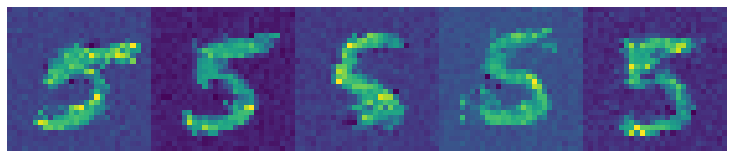

Epoch: 831/1600 Loss: -1335.7854
torch.Size([5, 28, 28])


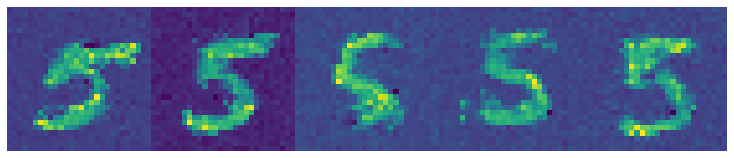

Epoch: 841/1600 Loss: -1324.9783
torch.Size([5, 28, 28])


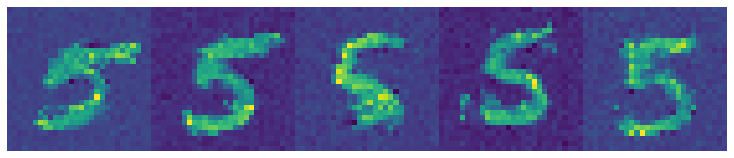

Epoch: 851/1600 Loss: -1310.7066
torch.Size([5, 28, 28])


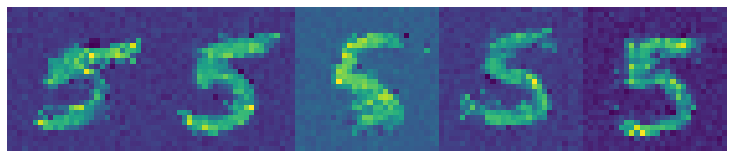

Epoch: 861/1600 Loss: -1333.3091
torch.Size([5, 28, 28])


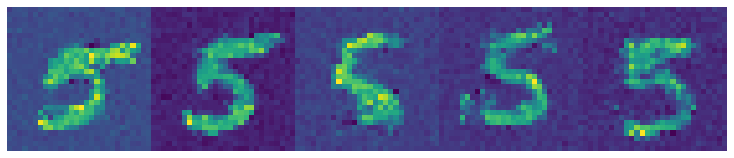

Epoch: 871/1600 Loss: -1330.7098
torch.Size([5, 28, 28])


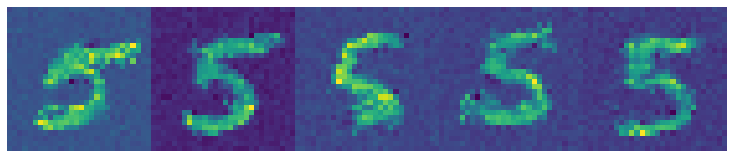

Epoch: 881/1600 Loss: -1320.2294
torch.Size([5, 28, 28])


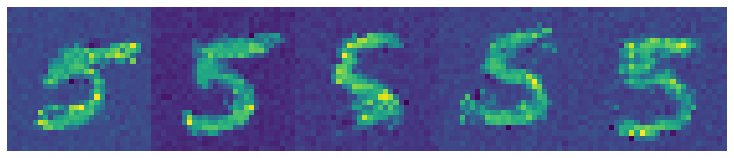

Epoch: 891/1600 Loss: -1334.1404
torch.Size([5, 28, 28])


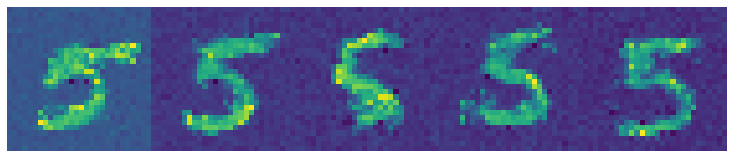

Epoch: 901/1600 Loss: -1332.1199
torch.Size([5, 28, 28])


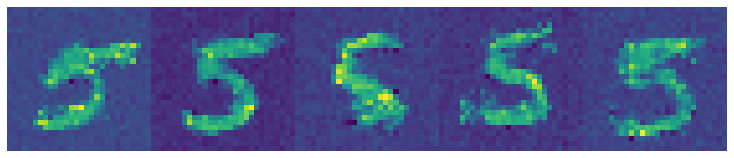

Epoch: 911/1600 Loss: -1332.4129
torch.Size([5, 28, 28])


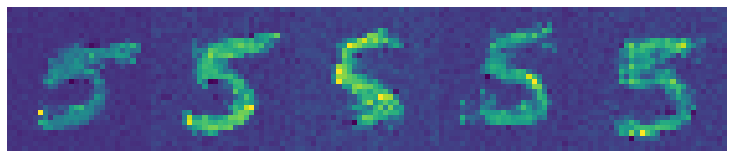

Epoch: 921/1600 Loss: -1336.2763
torch.Size([5, 28, 28])


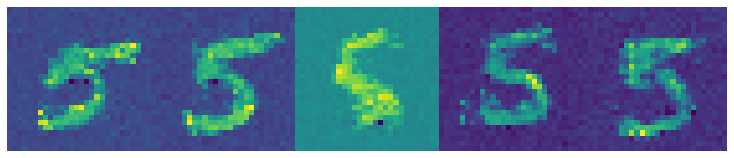

Epoch: 931/1600 Loss: -1300.9425
torch.Size([5, 28, 28])


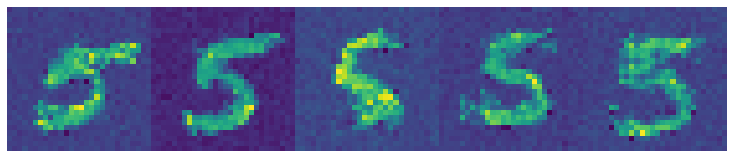

Epoch: 941/1600 Loss: -1331.0445
torch.Size([5, 28, 28])


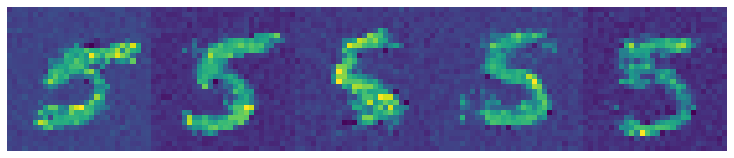

Epoch: 951/1600 Loss: -1335.8089
torch.Size([5, 28, 28])


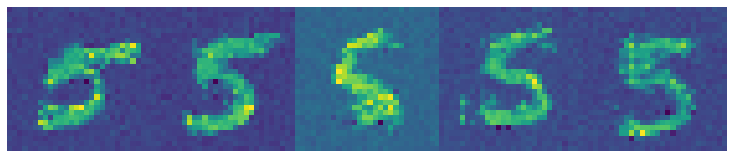

Epoch: 961/1600 Loss: -1327.9769
torch.Size([5, 28, 28])


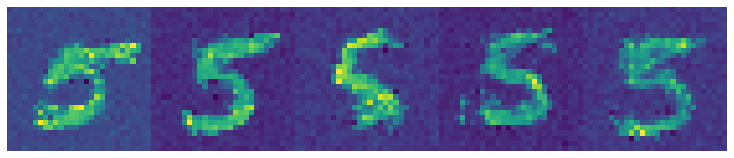

Epoch: 971/1600 Loss: -1330.7380
torch.Size([5, 28, 28])


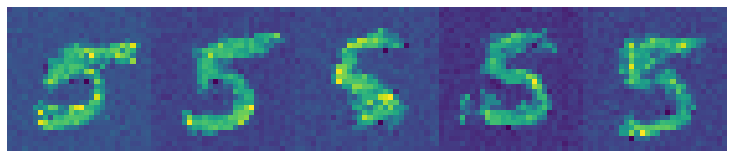

Epoch: 981/1600 Loss: -1333.1433
torch.Size([5, 28, 28])


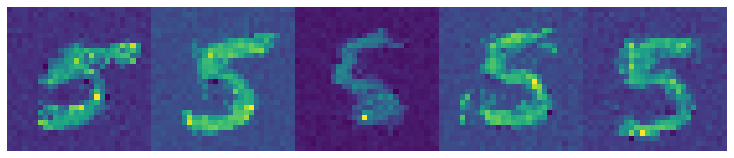

Epoch: 991/1600 Loss: -1325.1886
torch.Size([5, 28, 28])


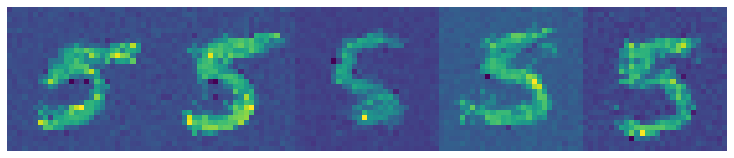

Epoch: 1001/1600 Loss: -1314.6194
torch.Size([5, 28, 28])


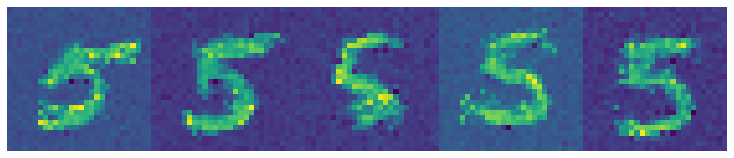

Epoch: 1011/1600 Loss: -1333.4090
torch.Size([5, 28, 28])


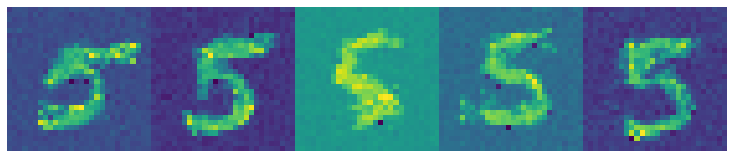

Epoch: 1021/1600 Loss: -1335.1547
torch.Size([5, 28, 28])


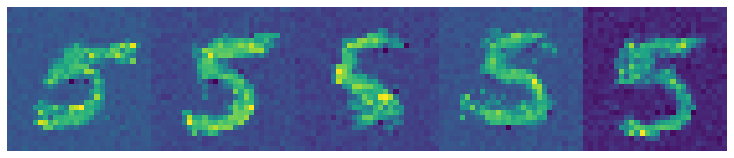

Epoch: 1031/1600 Loss: -1332.7616
torch.Size([5, 28, 28])


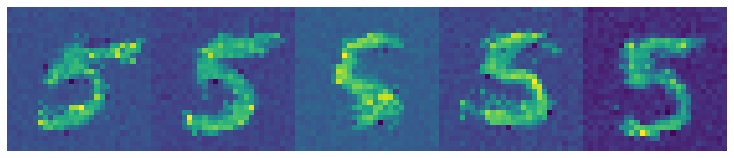

Epoch: 1041/1600 Loss: -1320.2411
torch.Size([5, 28, 28])


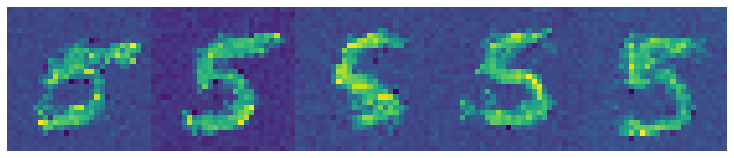

Epoch: 1051/1600 Loss: -1337.1205
torch.Size([5, 28, 28])


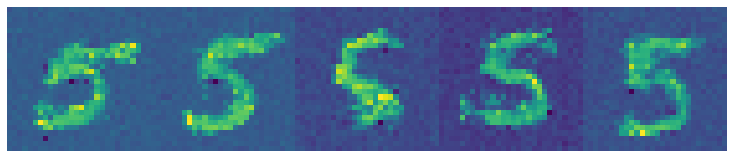

Epoch: 1061/1600 Loss: -1331.7193
torch.Size([5, 28, 28])


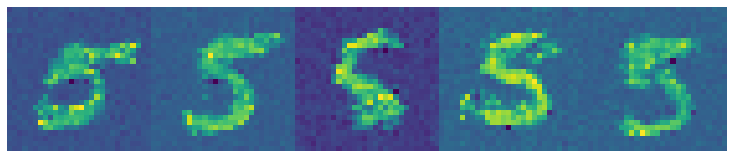

Epoch: 1071/1600 Loss: -1332.2470
torch.Size([5, 28, 28])


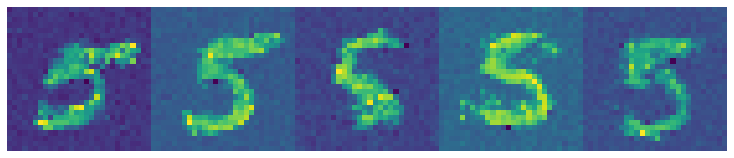

Epoch: 1081/1600 Loss: -1330.5563
torch.Size([5, 28, 28])


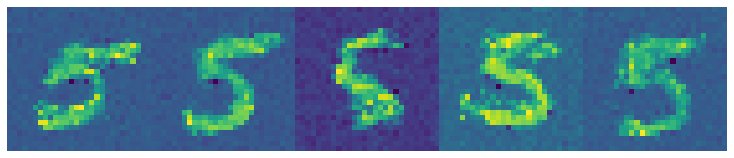

Epoch: 1091/1600 Loss: -1333.4374
torch.Size([5, 28, 28])


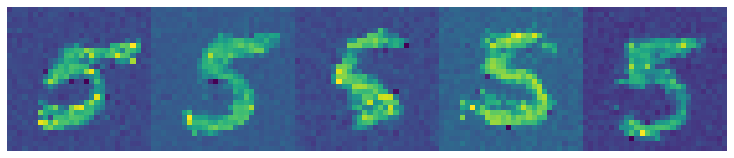

Epoch: 1101/1600 Loss: -1327.4756
torch.Size([5, 28, 28])


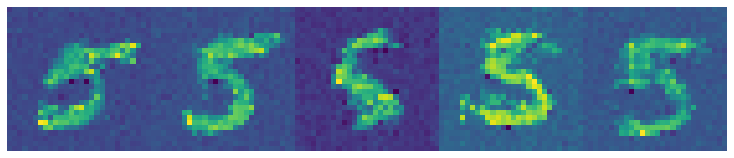

Epoch: 1111/1600 Loss: -1335.8833
torch.Size([5, 28, 28])


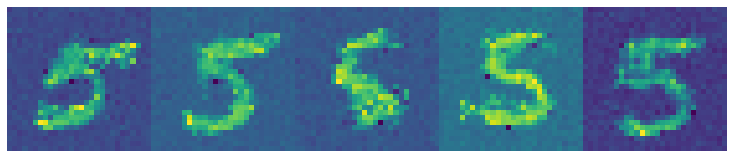

Epoch: 1121/1600 Loss: -1330.8000
torch.Size([5, 28, 28])


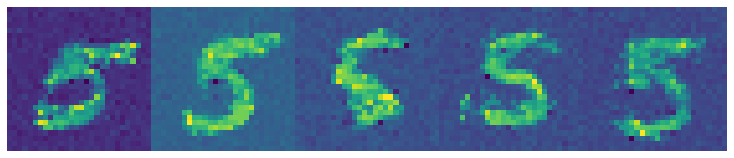

Epoch: 1131/1600 Loss: -1331.2082
torch.Size([5, 28, 28])


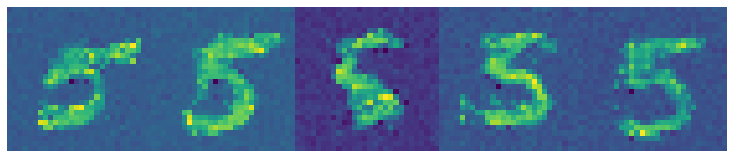

Epoch: 1141/1600 Loss: -1326.7905
torch.Size([5, 28, 28])


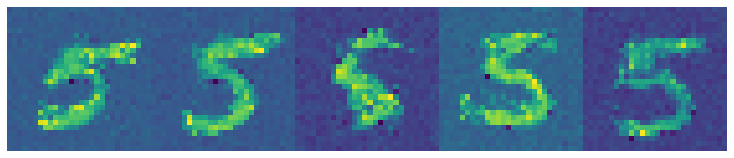

Epoch: 1151/1600 Loss: -1338.0861
torch.Size([5, 28, 28])


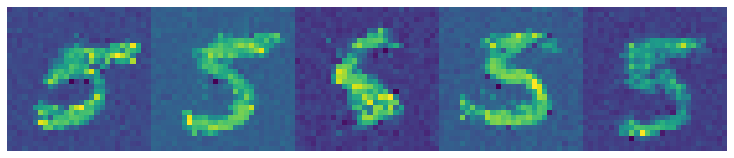

Epoch: 1161/1600 Loss: -1332.1083
torch.Size([5, 28, 28])


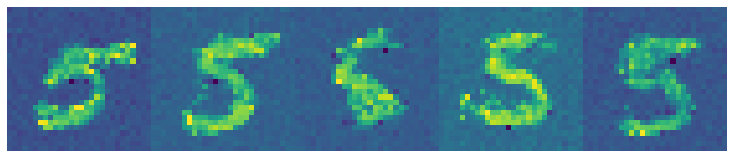

Epoch: 1171/1600 Loss: -1332.5831
torch.Size([5, 28, 28])


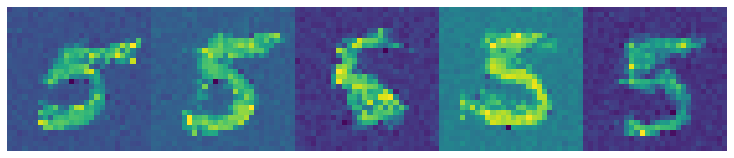

Epoch: 1181/1600 Loss: -1335.9428
torch.Size([5, 28, 28])


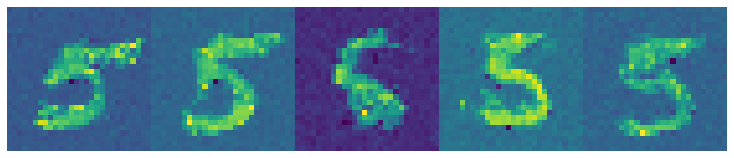

Epoch: 1191/1600 Loss: -1335.2285
torch.Size([5, 28, 28])


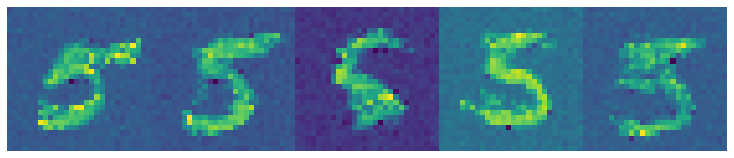

Epoch: 1201/1600 Loss: -1335.1162
torch.Size([5, 28, 28])


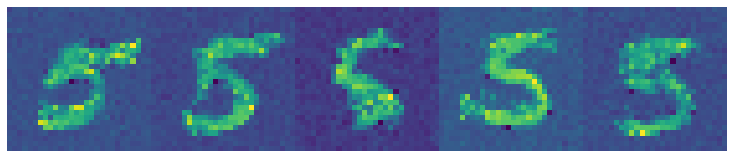

Epoch: 1211/1600 Loss: -1325.5132
torch.Size([5, 28, 28])


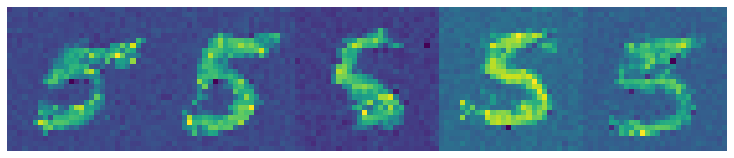

Epoch: 1221/1600 Loss: -1337.1495
torch.Size([5, 28, 28])


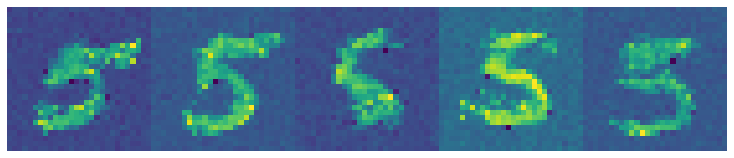

Epoch: 1231/1600 Loss: -1326.9664
torch.Size([5, 28, 28])


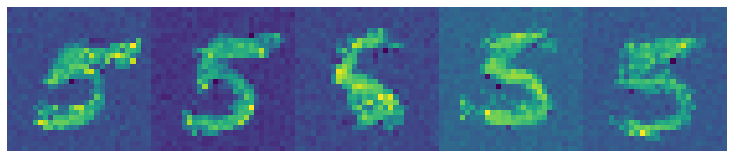

Epoch: 1241/1600 Loss: -1336.0678
torch.Size([5, 28, 28])


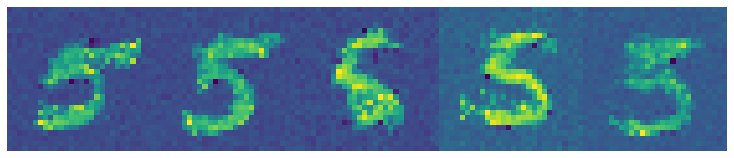

Epoch: 1251/1600 Loss: -1335.6383
torch.Size([5, 28, 28])


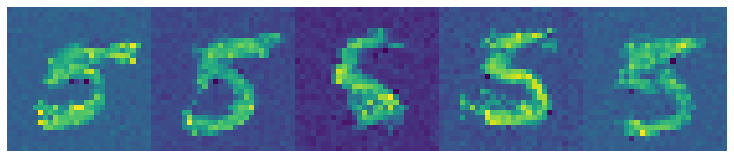

Epoch: 1261/1600 Loss: -1317.5860
torch.Size([5, 28, 28])


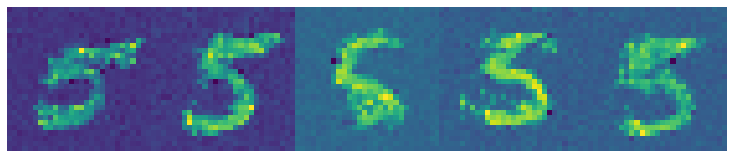

Epoch: 1271/1600 Loss: -1321.4770
torch.Size([5, 28, 28])


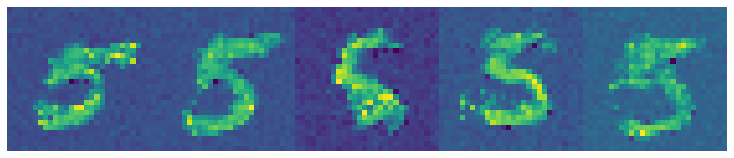

Epoch: 1281/1600 Loss: -1340.1118
torch.Size([5, 28, 28])


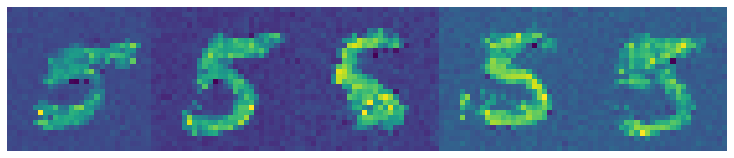

Epoch: 1291/1600 Loss: -1326.3136
torch.Size([5, 28, 28])


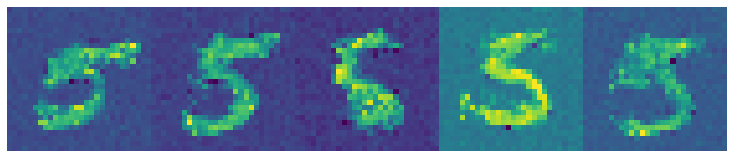

Epoch: 1301/1600 Loss: -1331.2240
torch.Size([5, 28, 28])


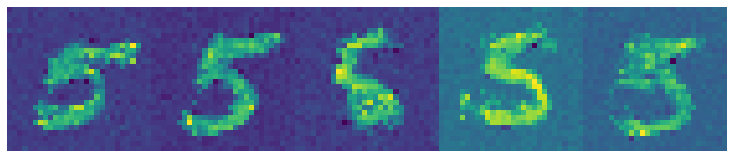

Epoch: 1311/1600 Loss: -1337.9380
torch.Size([5, 28, 28])


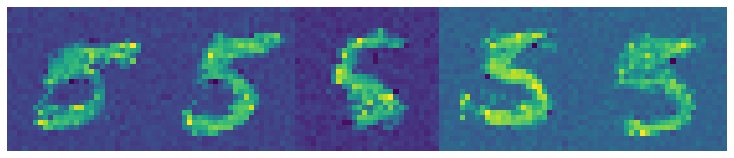

Epoch: 1321/1600 Loss: -1336.3780
torch.Size([5, 28, 28])


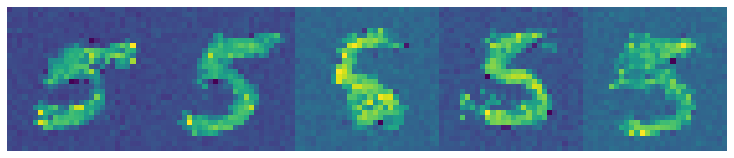

Epoch: 1331/1600 Loss: -1333.1386
torch.Size([5, 28, 28])


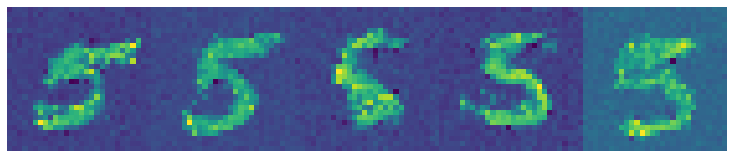

Epoch: 1341/1600 Loss: -1325.9856
torch.Size([5, 28, 28])


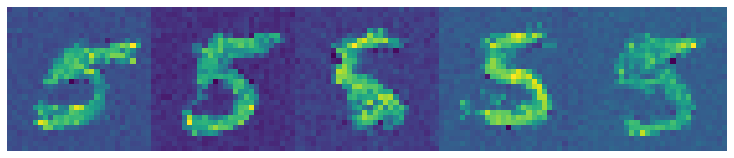

Epoch: 1351/1600 Loss: -1331.1663
torch.Size([5, 28, 28])


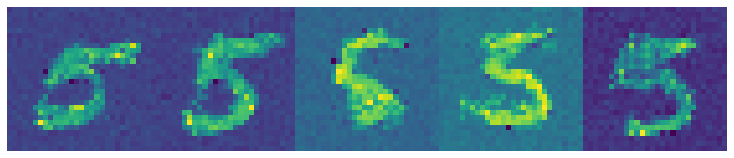

Epoch: 1361/1600 Loss: -1329.1941
torch.Size([5, 28, 28])


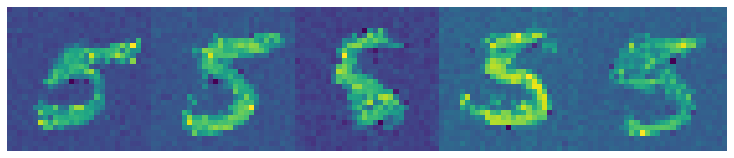

Epoch: 1371/1600 Loss: -1333.4052
torch.Size([5, 28, 28])


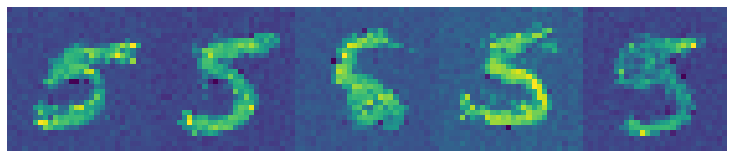

Epoch: 1381/1600 Loss: -1333.6397
torch.Size([5, 28, 28])


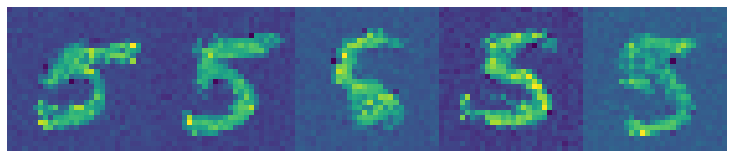

Epoch: 1391/1600 Loss: -1325.1145
torch.Size([5, 28, 28])


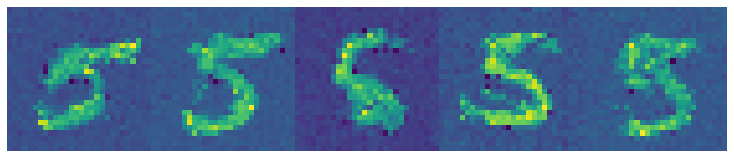

Epoch: 1401/1600 Loss: -1331.5454
torch.Size([5, 28, 28])


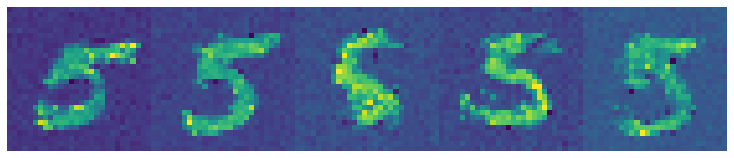

Epoch: 1411/1600 Loss: -1337.6676
torch.Size([5, 28, 28])


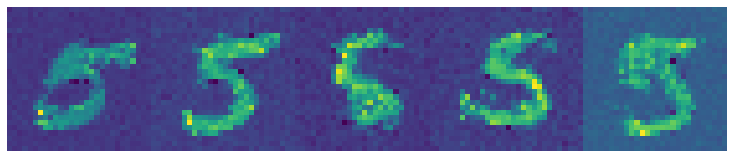

Epoch: 1421/1600 Loss: -1333.8714
torch.Size([5, 28, 28])


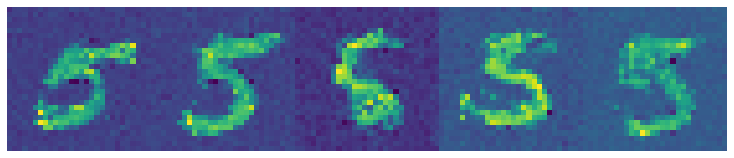

Epoch: 1431/1600 Loss: -1336.1333
torch.Size([5, 28, 28])


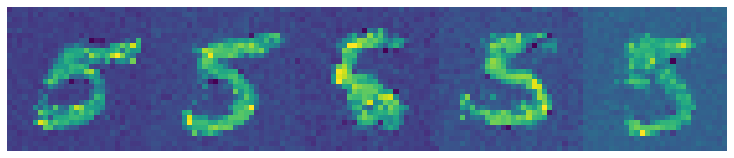

Epoch: 1441/1600 Loss: -1252.2429
torch.Size([5, 28, 28])


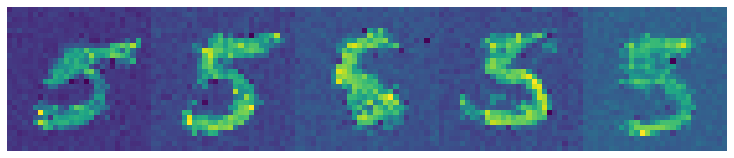

Epoch: 1451/1600 Loss: -1327.6514
torch.Size([5, 28, 28])


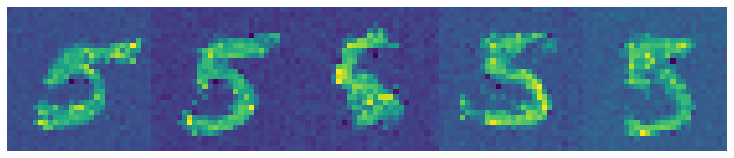

Epoch: 1461/1600 Loss: -1334.0117
torch.Size([5, 28, 28])


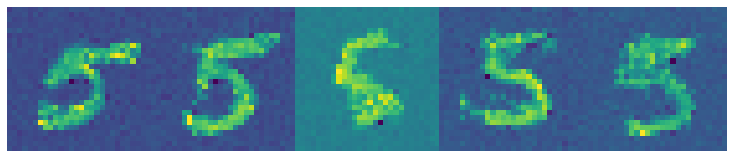

Epoch: 1471/1600 Loss: -1337.5189
torch.Size([5, 28, 28])


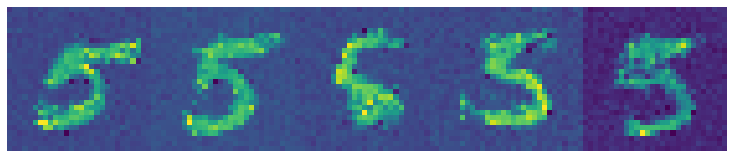

Epoch: 1481/1600 Loss: -1333.6419
torch.Size([5, 28, 28])


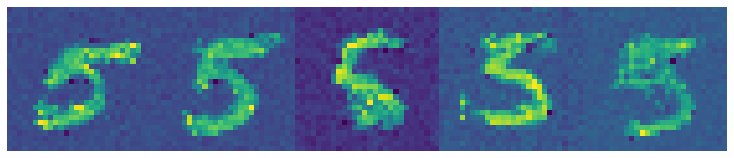

Epoch: 1491/1600 Loss: -1331.2160
torch.Size([5, 28, 28])


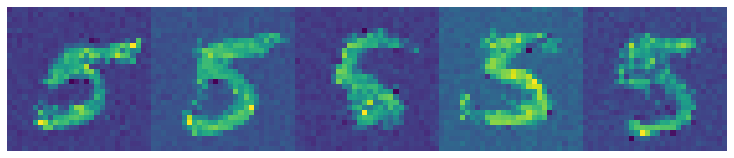

Epoch: 1501/1600 Loss: -1334.0034
torch.Size([5, 28, 28])


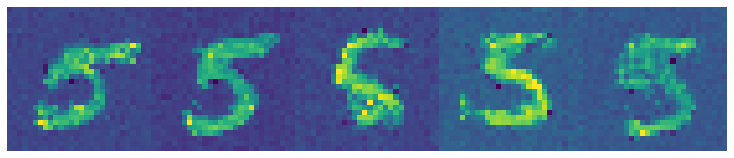

Epoch: 1511/1600 Loss: -1320.2025
torch.Size([5, 28, 28])


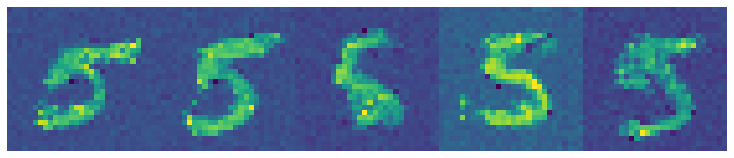

Epoch: 1521/1600 Loss: -1332.7432
torch.Size([5, 28, 28])


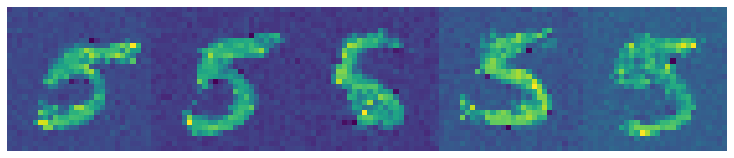

Epoch: 1531/1600 Loss: -1331.3089
torch.Size([5, 28, 28])


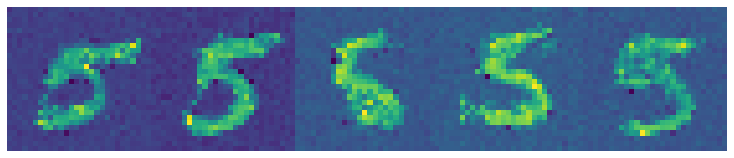

Epoch: 1541/1600 Loss: -1336.1334
torch.Size([5, 28, 28])


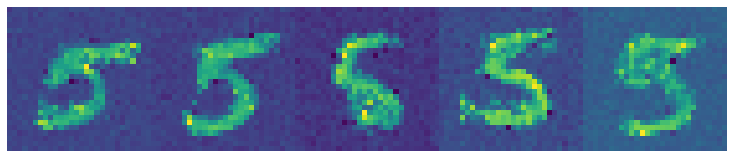

Epoch: 1551/1600 Loss: -1329.8868
torch.Size([5, 28, 28])


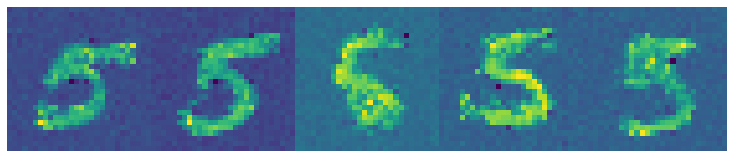

Epoch: 1561/1600 Loss: -1325.7092
torch.Size([5, 28, 28])


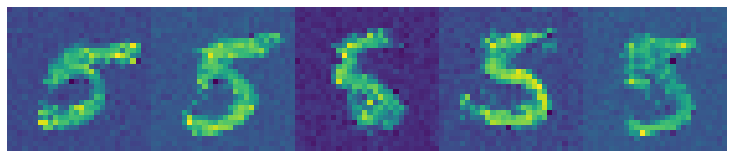

Epoch: 1571/1600 Loss: -1337.5173
torch.Size([5, 28, 28])


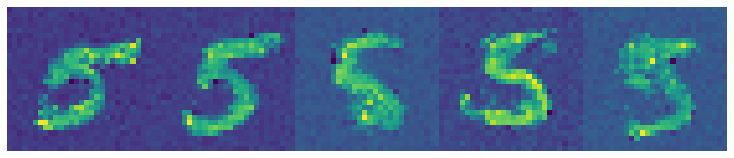

Epoch: 1581/1600 Loss: -1330.9500
torch.Size([5, 28, 28])


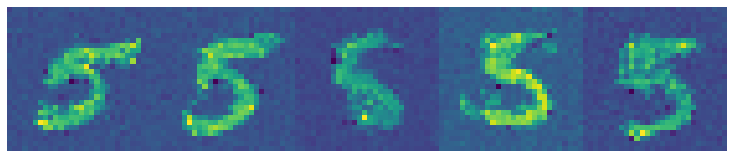

Epoch: 1591/1600 Loss: -1337.7641
torch.Size([5, 28, 28])


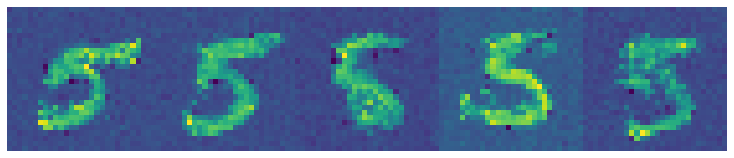

In [89]:
sample_noise = torch.randn(5,28,28).to(device)

for i in range(n_epochs):
    model.train()
    loss_acc = 0
    for j, x in enumerate(dataloader):
        optimizer.zero_grad()
        x = (x.float() + torch.randn(x.shape) / 64.).to(device)
        z, logdetJ = model.forward_flow(x)
        loss = nf_loss(z, logdetJ, base, device)
        loss_acc += loss.item()
        loss.backward()
        optimizer.step()
    
    if i%10 == 0:
        print(f'Epoch: {i + 1}/{n_epochs} Loss: {(loss_acc / (j+1)):.4f}')
        with torch.no_grad():
            model.eval()
            samples, r = model.inverse_flow(sample_noise)
            samples = samples.view(samples.shape[0], 28, 28)
            print(samples.shape)
            plot(samples)

In [90]:
torch.save(model.state_dict(), 'model.pth')

Najlepsze wyniki dla 6 warstw cupling layers. Dla 4 wartsw loss zatrzymywał się w okolicy 800. Więc lepiej zadziała głebsza sieć. Podobnie warstwy linear miałem z takimi samymi wymiarami, jak zmieniłem hidden_dim na 256 to udało się osiągnąć fajniejsze wyniki. Optimizer Adam z lr=1e-3, nie zmieniałem eps.
